In [257]:
import cv2
import numpy as np
from skimage import io
import gzip
import numpy as np
import cv2
from io import BytesIO

In [258]:
import nibabel as nib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go

### In below cell I tried to see the shape that each .nii file has.

In [259]:
nii_file_path = '/kaggle/input/biocliq/imagesTr_/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260_0000.nii'

# Load the .nii image
img = nib.load(nii_file_path)

# Get the image data as a NumPy array
img_data = img.get_fdata()

# Visualize a slice from the 3D volume
img_data.shape

(512, 512, 121)

In [260]:
nii_gz_path = '/kaggle/input/biocliq/imagesTr_/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260_0000.nii'

nii_data = nib.load(nii_file_path).get_fdata()
nii_data.shape

(512, 512, 121)

### Tried to plot one of the images that from one of the .nii files.
### Whichever files I opened I saw that there are 3D images with the third dimension that is the number of image channels or stacks being variable in most images.

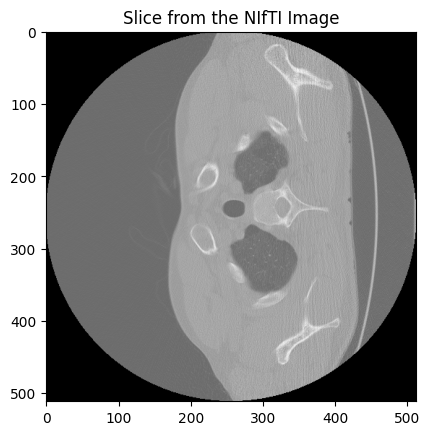

In [261]:
plt.imshow(nii_data[:, :, 110], cmap='gray')
plt.title('Slice from the NIfTI Image')
plt.show()

### Realised that labels is also the same shape, and therefore there is a label associated with each pixel, which defines to which category they belong to.

In [262]:
lbl_nii_file_path = '/kaggle/input/biocliq/labelsTr_/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.nii'

# Load the NIfTI image
lbl = nib.load(lbl_nii_file_path)

# Get the image data as a NumPy array
lbl_data = lbl.get_fdata()

# Visualize a slice from the 3D volume (assuming a 3D image)
lbl_data.shape

(512, 512, 121)

### Plotting the label image for the above plotted image and saw four category in the segmented images.

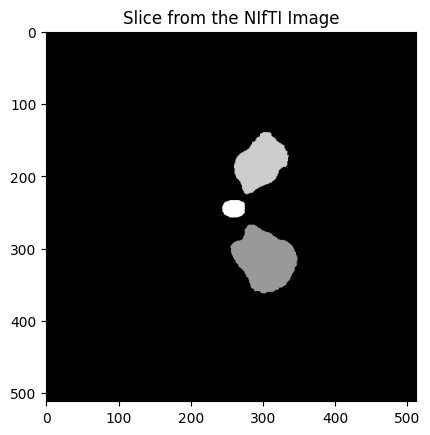

In [263]:
plt.imshow(lbl_data[:, :, 110], cmap='gray')
plt.title('Slice from the NIfTI Image')
plt.show()

### The below cell provided me the insight to which classes the pixels belong to, and what are the number of of values with respect to each class

In [264]:
# Create a NumPy array (replace this with your array)
my_array = lbl_data[:,:,110]

# Get unique values and their counts
unique_values, counts = np.unique(my_array, return_counts=True)

# Print or use the unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0.0, Count: 251773
Value: 3.0, Count: 5716
Value: 4.0, Count: 4016
Value: 5.0, Count: 639


### In the below cell, I tried to create a way to eliminate the trachea label by changing it's class to the same as that of background class, amalgamate the left and right lung masks into a single label by changing it's class to 1.

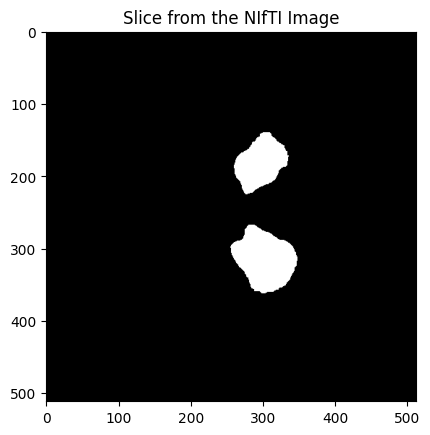

In [265]:
# Eliminate label 5
label_array = np.copy(lbl_data[:,:,110])

label_array[label_array == 5] = 0  # Set all occurrences of label 3 to 0 or any other suitable background label

# Amalgamate labels 3 and 4
label_array[(label_array == 4) | (label_array == 3)] = 1

plt.imshow(label_array, cmap='gray')
plt.title('Slice from the NIfTI Image')
plt.show()

In [266]:
import os
from sklearn.model_selection import train_test_split

### Transformed the dataset into training, validation and testing dataset for both images and labels. I currently have the list of file paths for both images and labels being splitted into train, validation and test sets.

In [267]:
images_folder = '/kaggle/input/biocliq/imagesTr_'
labels_folder = '/kaggle/input/biocliq/labelsTr_'

# List all image and label files
image_files = [os.path.join(images_folder, file) for file in os.listdir(images_folder)]
label_files = [os.path.join(labels_folder, file) for file in os.listdir(labels_folder)]

# Sort both lists to ensure consistent pairing
image_files.sort()
label_files.sort()

# Split the data into train, val, and test sets
train_files, test_files = train_test_split(list(zip(image_files, label_files)), test_size=0.2, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=0.2, random_state=42)

# Unzip the pairs
train_image_files, train_label_files = zip(*train_files)
val_image_files, val_label_files = zip(*val_files)
test_image_files, test_label_files = zip(*test_files)

In [268]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

### As we had to calculate the Dice score for final evaluation, I chose to calculate the Dice Loss, on which I will try to minimize the loss to better train my data ove training image and label sets

In [269]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, target):
        smooth = 1e-5
        inputs = torch.sigmoid(inputs)

        # Flatten the predictions and labels
        input_flat = inputs.reshape(-1)
        target_flat = target.reshape(-1)

        intersection = (input_flat * target_flat).sum()
        union = input_flat.sum() + target_flat.sum()

        dice_score = (2. * intersection + smooth) / (union + smooth)

        # Dice Loss is 1 - Dice Score
        dice_loss = 1.0 - dice_score

        return dice_loss

dice_loss = DiceLoss()

### Here I have created a basic CNN model like an autoencoder one over which I try to experiment my segmentation task.

#### Encoder Layer:
#### The encoder consists of convolutional layers and a max pooling layer. The encoder's role is typically to extract and downsample features from the input image. It starts with a Conv2d layer with 100 input channels, 64 output channels, a kernel size of 3, stride 1, and no padding. This is followed by a ReLU activation function. Another Conv2d layer follows with the same parameters, but with padding set to 1. Finally, a MaxPool2d layer with a kernel size of 3, stride 1, and padding 1 is used, which interestingly doesn't perform downsampling due to its stride and padding settings.

#### Middle Layer:
#### The middle layer further processes the features using two Conv2d layers (both with 32 channels) and a MaxPool2d layer, similar to the encoder. Again, due to the stride and padding settings, the spatial dimensions of the feature map are not reduced.

#### Decoder Layer:
#### The decoder aims to upsample the features and reconstruct the output from the encoded features. It starts with a ConvTranspose2d layer, with 32 input channels and 64 output channels, a kernel size of 3, stride 1, and no padding. This is followed by two Conv2d layers and ReLU activations, similar to the previous layers. The final Conv2d layer has 100 output channels, matching the number of input channels at the start of the encoder, suggesting that the network might be designed for tasks like image reconstruction or segmentation where the output dimensions match the input.

In [270]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn, self).__init__()

        # Encoder (contracting path)
        self.encoder = nn.Sequential(
            nn.Conv2d(100, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1)  # No downsampling
        )

        # Middle layer
        self.middle = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1)  # No downsampling
        )

        # Decoder (expanding path)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=1, padding=0),  # No upsampling
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 100, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        # Encoder
        x1 = self.encoder(x)

        # Middle layer
        x2 = self.middle(x1)

        # Decoder
        x3 = self.decoder(x2)

        return x3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    


model = Cnn().to(device)


# Print the model architecture
print(model)

# Set up the loss function and optimizer
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# model.summary()

Cnn(
  (encoder): Sequential(
    (0): Conv2d(100, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (middle): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


### In the below cell I have written code for my own dataloader like functionality, as I had a very tough time to get the dataset from the training image and label paths which I stored in above cells. Also I have also implemented training and validation loops in the below cell, and for each epoch I am taking first 100 images from each .nii file as the files that I opened each has more than 100 images, so I assumed that atleast 100 images of 512 x 512 size will be there. Also after each epoch I am checking if the validation loss as compared to previous loss is greater than some threshold, I will use it for Early Stopping. (I have set threshold = 0.01)
### Also while taking the labels I have eliminated the trachea labels and amalgamate the left and right lung masks into a single label.

In [271]:
train_loss_list = []
val_loss_list = [1.0]
epochs = 50
curr_epoch = 0
for epoch in range(epochs):
    train_loss = 0.0
    curr_epoch = epoch+1
    for i in range(len(train_image_files)):
        
        image = nib.load(train_image_files[i]).get_fdata()[:,:,:100].transpose(2,0,1)
        image = torch.tensor(image.reshape((1,) + image.shape), dtype = torch.float32)
        image = torch.tensor(image, dtype = torch.float32).to(device)
        label = nib.load(train_label_files[i]).get_fdata()[:,:,:100]
        label[label == 5] = 0  # Set all occurrences of label 3 to 0 or any other suitable background label
        # Amalgamate labels 3 and 4
        label[(label == 4) | (label == 3)] = 1
        label = label.transpose(2,0,1)
        label = torch.tensor(label.reshape((1,) + label.shape), dtype = torch.float32)
        label = torch.tensor(label, dtype = torch.float32).to(device)
#         print(image.shape)
        prediction = model(image)
#         print(prediction.shape, label.shape)
    
        loss = criterion(prediction, label)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss_list.append(train_loss/len(train_image_files))
        # Print loss
    print(f"Epoch {epoch+1}, Training Loss: {train_loss/len(train_image_files)}")
        
    val_loss = 0.0
    with torch.no_grad():
        for i in range(len(val_image_files)):
            image = nib.load(train_image_files[i]).get_fdata()[:,:,:100].transpose(2,0,1)
            image = torch.tensor(image.reshape((1,) + image.shape), dtype = torch.float32)
            image = torch.tensor(image, dtype = torch.float32).to(device)
            label = nib.load(train_label_files[i]).get_fdata()[:,:,:100]
            label[label == 5] = 0  # Set all occurrences of label 3 to 0 or any other suitable background label
            # Amalgamate labels 3 and 4
            label[(label == 4) | (label == 3)] = 1
            label = label.transpose(2,0,1)
            label = torch.tensor(label.reshape((1,) + label.shape), dtype = torch.float32)
            label = torch.tensor(label, dtype = torch.float32).to(device)
            
            outputs = model(image)
            loss = criterion(outputs, label)
            val_loss += loss.item()
        val_loss_list.append(val_loss/len(val_image_files))
        print(f"Epoch {epoch+1}, Validation Loss: {val_loss/len(val_image_files)}")
        if(val_loss_list[-1] - val_loss_list[-2] > 0.01):
            print("-----validation loss increased------")
            break

/tmp/ipykernel_346/231190028.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype = torch.float32).to(device)
/tmp/ipykernel_346/231190028.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype = torch.float32).to(device)


Epoch 1, Training Loss: 0.7739599858011518


/tmp/ipykernel_346/231190028.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype = torch.float32).to(device)
/tmp/ipykernel_346/231190028.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype = torch.float32).to(device)


Epoch 1, Validation Loss: 0.7976761609315872
Epoch 2, Training Loss: 0.5748788373810905
Epoch 2, Validation Loss: 0.627826139330864
Epoch 3, Training Loss: 0.4875364920922688
Epoch 3, Validation Loss: 0.525186188519001
Epoch 4, Training Loss: 0.44493940685476574
Epoch 4, Validation Loss: 0.5157109722495079
Epoch 5, Training Loss: 0.4500450385468347
Epoch 5, Validation Loss: 0.49332549422979355
Epoch 6, Training Loss: 0.4455954815660204
Epoch 6, Validation Loss: 0.49050699174404144
Epoch 7, Training Loss: 0.4441872260400227
Epoch 7, Validation Loss: 0.5052192956209183
-----validation loss increased------


### Below I try to see one of the outputs and tried to compare it visually with the real output label.

/tmp/ipykernel_346/4233159869.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype = torch.float32).to(device)
/tmp/ipykernel_346/4233159869.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype = torch.float32).to(device)


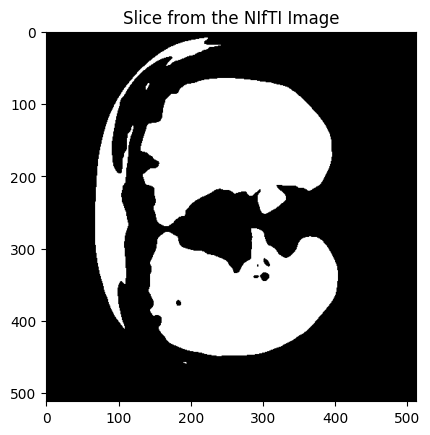

In [272]:
image = nib.load(train_image_files[0]).get_fdata()[:,:,:100].transpose(2,0,1)
image = torch.tensor(image.reshape((1,) + image.shape), dtype = torch.float32)
image = torch.tensor(image, dtype = torch.float32).to(device)
label = nib.load(train_label_files[0]).get_fdata()[:,:,:100]
label[label == 5] = 0  # Set all occurrences of label 3 to 0 or any other suitable background label
# Amalgamate labels 3 and 4
label[(label == 4) | (label == 3)] = 1
label = label.transpose(2,0,1)
label = torch.tensor(label.reshape((1,) + label.shape), dtype = torch.float32)
label = torch.tensor(label, dtype = torch.float32).to(device)
prediction = model(image)
# prediction.shape
prediction = torch.sigmoid(prediction)
prediction_img = prediction[0,99,:,:].detach().cpu().numpy()
plt.imshow(prediction_img, cmap='gray')
plt.title('Slice from the NIfTI Image')
plt.show()        

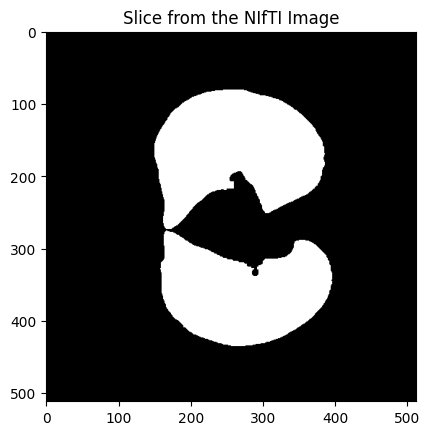

In [273]:
label_img = label[0,99,:,:].detach().cpu().numpy()
plt.imshow(label_img, cmap='gray')
plt.title('Slice from the NIfTI Image')
plt.show()        

### Plotting the training loss and validation loss for the epochs till when early stopping hasn't been applied to.

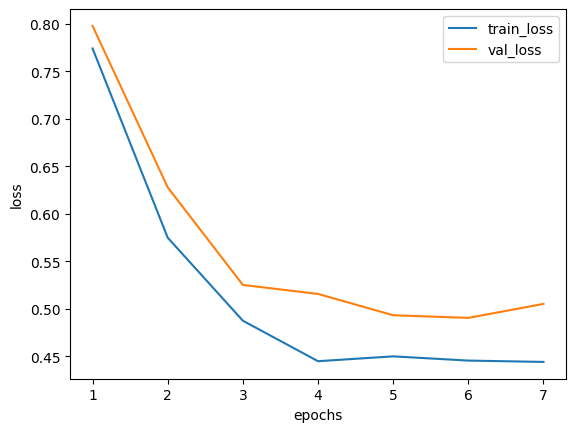

In [274]:
def plot(train_loss , val_loss , epoch):
    plt.plot(range(1,epoch+1),train_loss,label='train_loss')
    plt.plot(range(1,epoch+1),val_loss,label='val_loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

plot(train_loss_list, val_loss_list[1:], curr_epoch)

### Saving the models current state as we had to store the model weights as well.

In [277]:
model_path = './'
if os.path.exists(model_path+"segmentation.pth"):
    os.remove(model_path+"segmentation.pth")
    print("File deleted")
    
# Now save the new model
torch.save(model.state_dict(), model_path+"segmentation.pth")
print("File uploaded")

File deleted
File uploaded


### Running the test evaluation on the test image and label dataset and getting the test dice loss

In [275]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for i in range(len(test_image_files)):
        image = nib.load(test_image_files[i]).get_fdata()[:,:,:100].transpose(2,0,1)
        image = torch.tensor(image.reshape((1,) + image.shape), dtype = torch.float32)
        image = torch.tensor(image, dtype = torch.float32).to(device)
        label = nib.load(test_label_files[i]).get_fdata()[:,:,:100]
        label[label == 5] = 0  # Set all occurrences of label 3 to 0 or any other suitable background label
        # Amalgamate labels 3 and 4
        label[(label == 4) | (label == 3)] = 1
        label = label.transpose(2,0,1)
        label = torch.tensor(label.reshape((1,) + label.shape), dtype = torch.float32)
        label = torch.tensor(label, dtype = torch.float32).to(device)
        outputs = model(image)
        loss = criterion(outputs, label)
        test_loss += loss.item()

    test_loss /= len(test_image_files)
    print('Final Test Loss:', test_loss)

/tmp/ipykernel_346/2584995829.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype = torch.float32).to(device)
/tmp/ipykernel_346/2584995829.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype = torch.float32).to(device)


Final Test Loss: 0.39827821652094525


### Printing the final Dice Score I got for the above model (Dice Score = 1 - Dice Loss)

In [276]:
print("Final Dice Score:", 1-test_loss)

Final Dice Score: 0.6017217834790547
